# ML for climate and Energy (MEC51057)
# Group project: Weather station 2024-2025

<div class="alert alert-block alert-info">

**Mentor**:
- Julio 

**Students**:
- Dimitri Iratchet
- Fabien Lagnieu
- Tristan Waddington
</div> 

# "Final notebook"

Go to [quickstart](#253-final-dataset-reduced-and-normalized-measurments).

In [7]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import torch
import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from importlib import reload

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset

# Project imports
from src import load_data
from src import display
from src import DL_models

reload(load_data)
reload(display)
reload(DL_models)

<module 'src.DL_models' from '/Users/tristanwaddington/Documents/Informatique/Git_reps/ML_ClimateEnergy_project2024/src/DL_models.py'>

In [ ]:
# Constants
# Retrain Deep Learning models, if False, load the models from disk
RETRAIN_MODELS: bool = False

--- 
## 1. Project presentation

### 1.1 Gereral presentation

<div class="alert alert-block alert-info">

**Aim**: <br>
Paris weather station was cyber-hacked, and is therefore unable to share
its weather measures since the beginiing of 2019. **Our task is to predict this missing data from
other European weather stations measures**.

Furthermore, we suspect that since 2016 some reports have been modified by these 
hackers in a previous altering attack. We have to spot these modifications.

**Dataset**: <br>
We have access to the full history of measurements of 5 stations, including
Paris, reporting 10 weather variables that will be described bellow. 
The measures were reported hourly and span form year 1980 to 2019 (included, exact common timeframe: 1980-01-01 07:00:00 to 2019-12-31 23:00:00).

For educative purpose, we decided to split them on 3 different datasets:
- Confirmed clean timeframe (train): year 1980-2015
- Suspicious time-frame (test): year 2016-2018
- "Real time" stream (validation): year 2019

</div> 

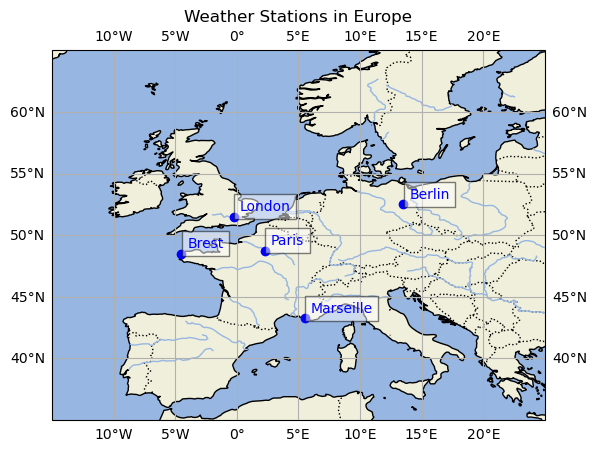

In [5]:
# Display the weather stations on a map, as illustration
display.display_weather_stations()

### 1.2 Data files presentation

<div class="alert alert-block alert-info">

**Raw format**: <br>
We are given the raw measurements of 5 weather stations in separate files, split by station and by feature. Each `.nc` file can be loaded with the `xarray` module in a specific format. 
</div> 

In [6]:
# Display the contents of the folder weater_data
data_folder = Path("data", "weather_data")
print("Contents of weather_data folder:")
for file in data_folder.iterdir():
    if file.is_dir():
        print(f"- {file.name}/")
        print(f"\t{"; ".join(sub_file.name for sub_file in file.iterdir())}")

Contents of weather_data folder:
- paris/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- marseille/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- brest/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- london/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- berlin/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc


In [ ]:
# display the explanation of the variables
print(
    "\n".join(":\t".join([var, legend]) for var, legend in display.var_legend.items())
)

t2m:	Air temperature at 2 m above the ground [K]
d2m:	Dew point at 2 m above the ground [K]
u10:	Zonal wind component at 10 m [m/s]
v10:	Meridional wind component at 10 m [m/s]
skt:	Skin temperature [K]
tcc:	Total cloud cover [0-1]
sp:	Surface pressure [Pa]
tp:	Total precipitation [m]
ssrd:	Surface solar radiation (downwards) [J/m^2]
blh:	Boundary layer height [m]


---
## 2. Data Loading / preparation / study

<div class="alert alert-block alert-info">

To facilitate the following study, **this files are merged onto `Pandas` `Dataframe`**.

**Treatment**: <br>
Given the physicial differences in the meaning and scale of each feature, we decided to
**normalize** the dataset **by feature** to use them in a machine learning process. But to be able to interpret back the results of our models, the inverse transformation should be available. That's why we specifically return the scalers during the loading process.

**Signification**: <br>
Each of the 10 features represent a physical measurement that is studied in the next part.
</div>

### 2.1 Load the xarrays and transform into Pandas DataFrame

In [ ]:
# Origin of the files
base_path: Path = Path("data", "weather_data")
# Load into a dictionary of all features by city
weather_stations_data: dict[str, pd.DataFrame] = load_data.load_nc_files_by_subfolders(
    base_path
)
# Get the names of the cities
cities: list[str] = list(weather_stations_data.keys())

# Display the description of Paris data
print("Description of Paris data:")
weather_stations_data["paris"].describe()


Description of Paris data:


,blh,d2m,skt,sp,ssrd,t2m,tcc,tp,u10,v10
count,359424.000000,359424.000000,359424.000000,359424.000000,3.594240e+05,359424.000000,359424.000000,359424.000000,359424.000000,359424.000000
mean,604.306396,280.462677,284.343475,100415.398438,4.776326e+05,284.404175,0.664978,0.000082,0.864824,0.351672
std,470.654724,5.681719,7.730994,906.625916,7.350270e+05,7.121849,0.369240,0.000297,2.641523,2.879269
min,9.829140,254.678604,252.089996,94526.585938,-1.901566e+00,256.771332,0.000000,0.000000,-9.424118,-10.220169
25%,205.043015,276.560242,278.848358,99890.281250,0.000000e+00,279.366882,0.347229,0.000000,-1.184677,-1.833076
50%,492.636017,280.908752,283.880219,100472.187500,2.099200e+04,284.210266,0.842072,0.000000,0.842087,0.232651
75%,915.939209,284.717285,289.336365,101001.007812,7.504640e+05,289.264038,0.998413,0.000009,2.671062,2.403114
max,3572.631348,295.901764,317.110504,103395.062500,3.315712e+06,314.154785,1.000000,0.011550,16.235458,14.881912


This confirms that the scale of each data is different. We will need to **normalize** the data before training a model.

### 2.2 Data exploration
Before transforming the data, let's study it.

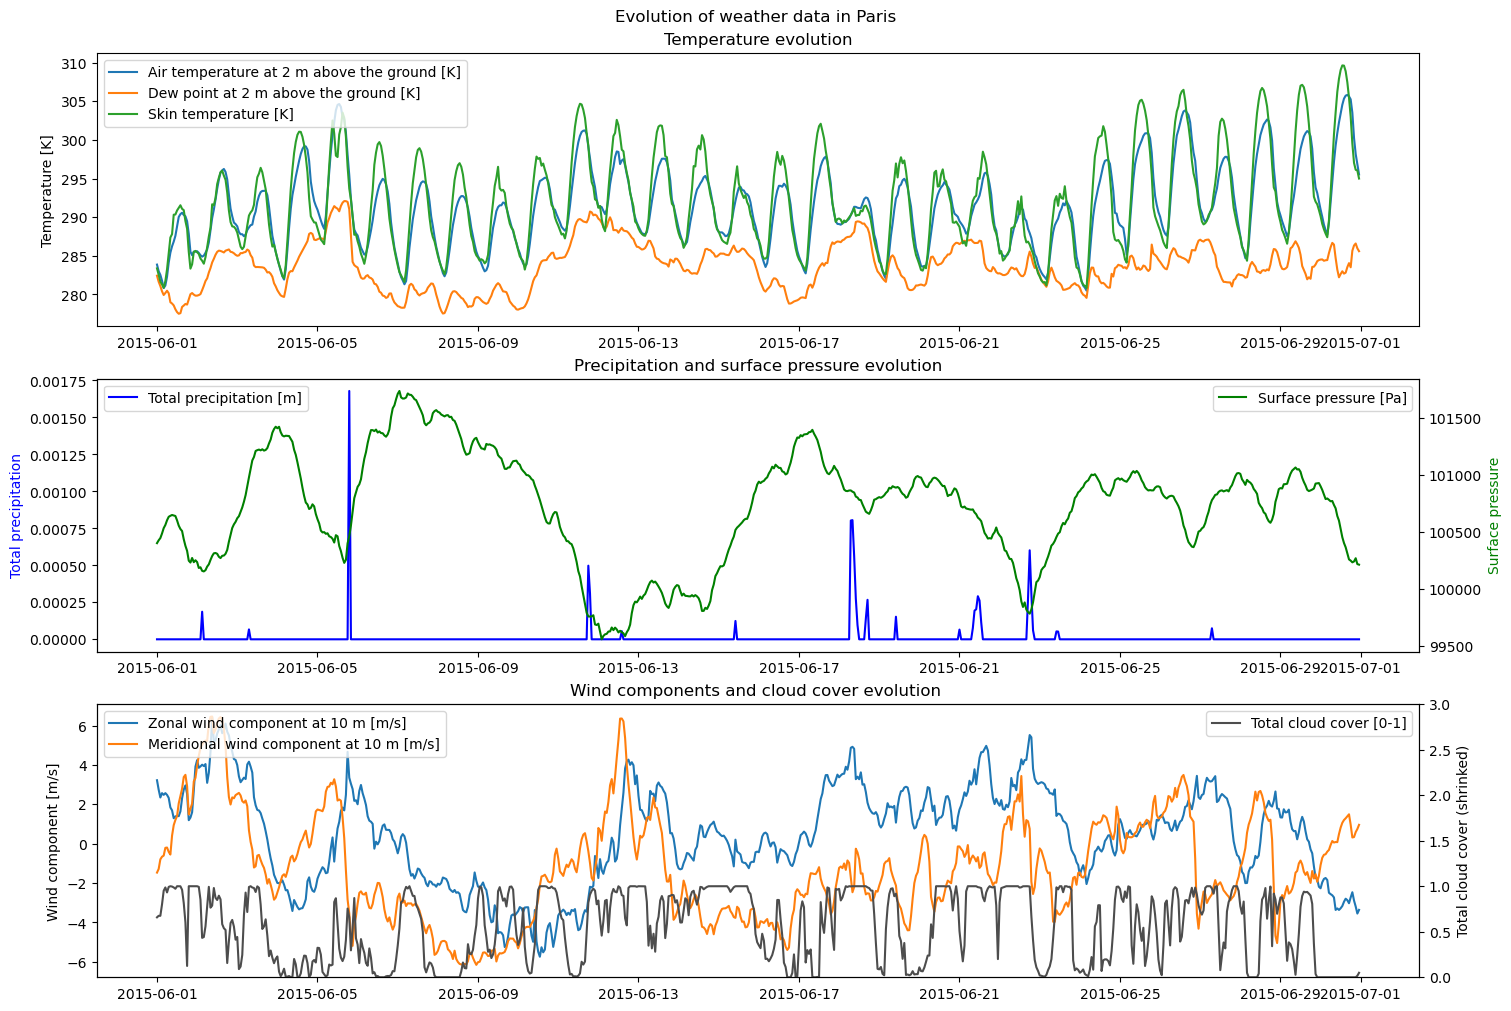

In [9]:
# Example of data for Paris June 2015
city: str = "paris"
start_date: str = "2015-06-01"
end_date: str = "2015-06-30"
paris_data_june_2015: pd.DataFrame = weather_stations_data[city].loc[
    start_date:end_date
]
display.display_weather_features(paris_data_june_2015, city)

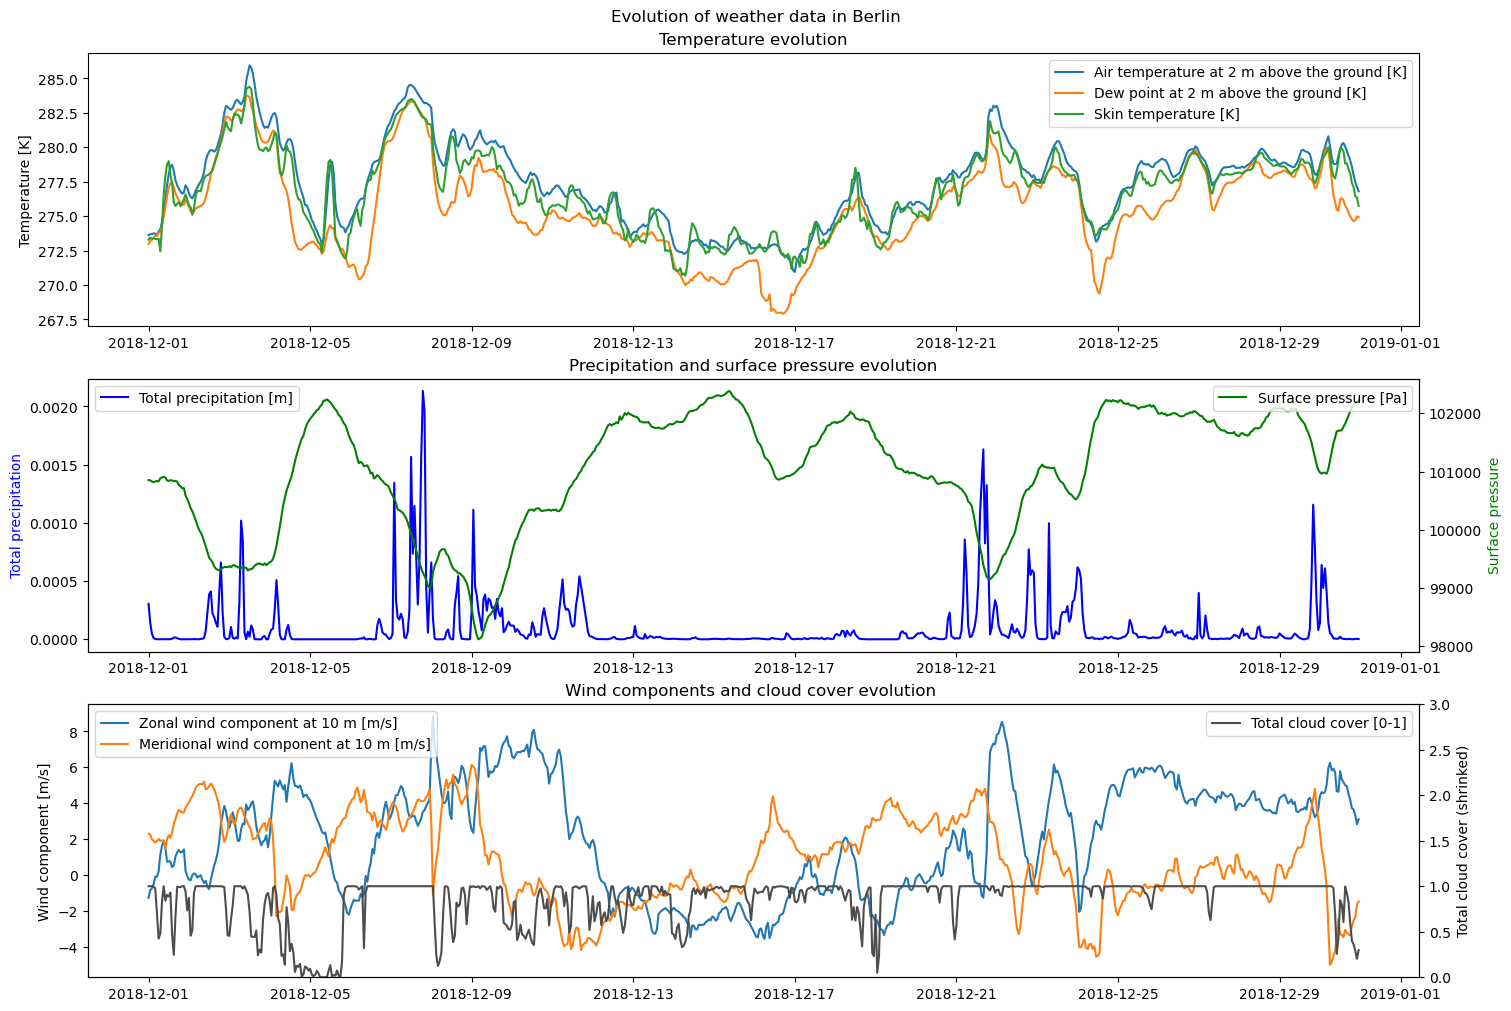

In [10]:
# Example of data for Berlin December 2018
city: str = "berlin"
start_date: str = "2018-12-01"
end_date: str = "2018-12-30"
berlin_data_dec_2018: pd.DataFrame = weather_stations_data[city].loc[
    start_date:end_date
]
display.display_weather_features(berlin_data_dec_2018, city)

<div class="alert alert-block alert-info">

**Correlation between features**: <br>
Some variables seems highly correlated, such as the 3 temperatures features(`t2m, d2m, skt`). Good sense also leads to a relation between the surface pressure and the rain (`sp`/`tp`).
</div>

### 2.3 Covariance study

The dataset is 3 dimensional, we have 2 kinds of covariance to explore: 
- the link between variables at the same time on the same city;
- the link between a variable across cities at the same time.

#### 2.3.1 Covariance between features

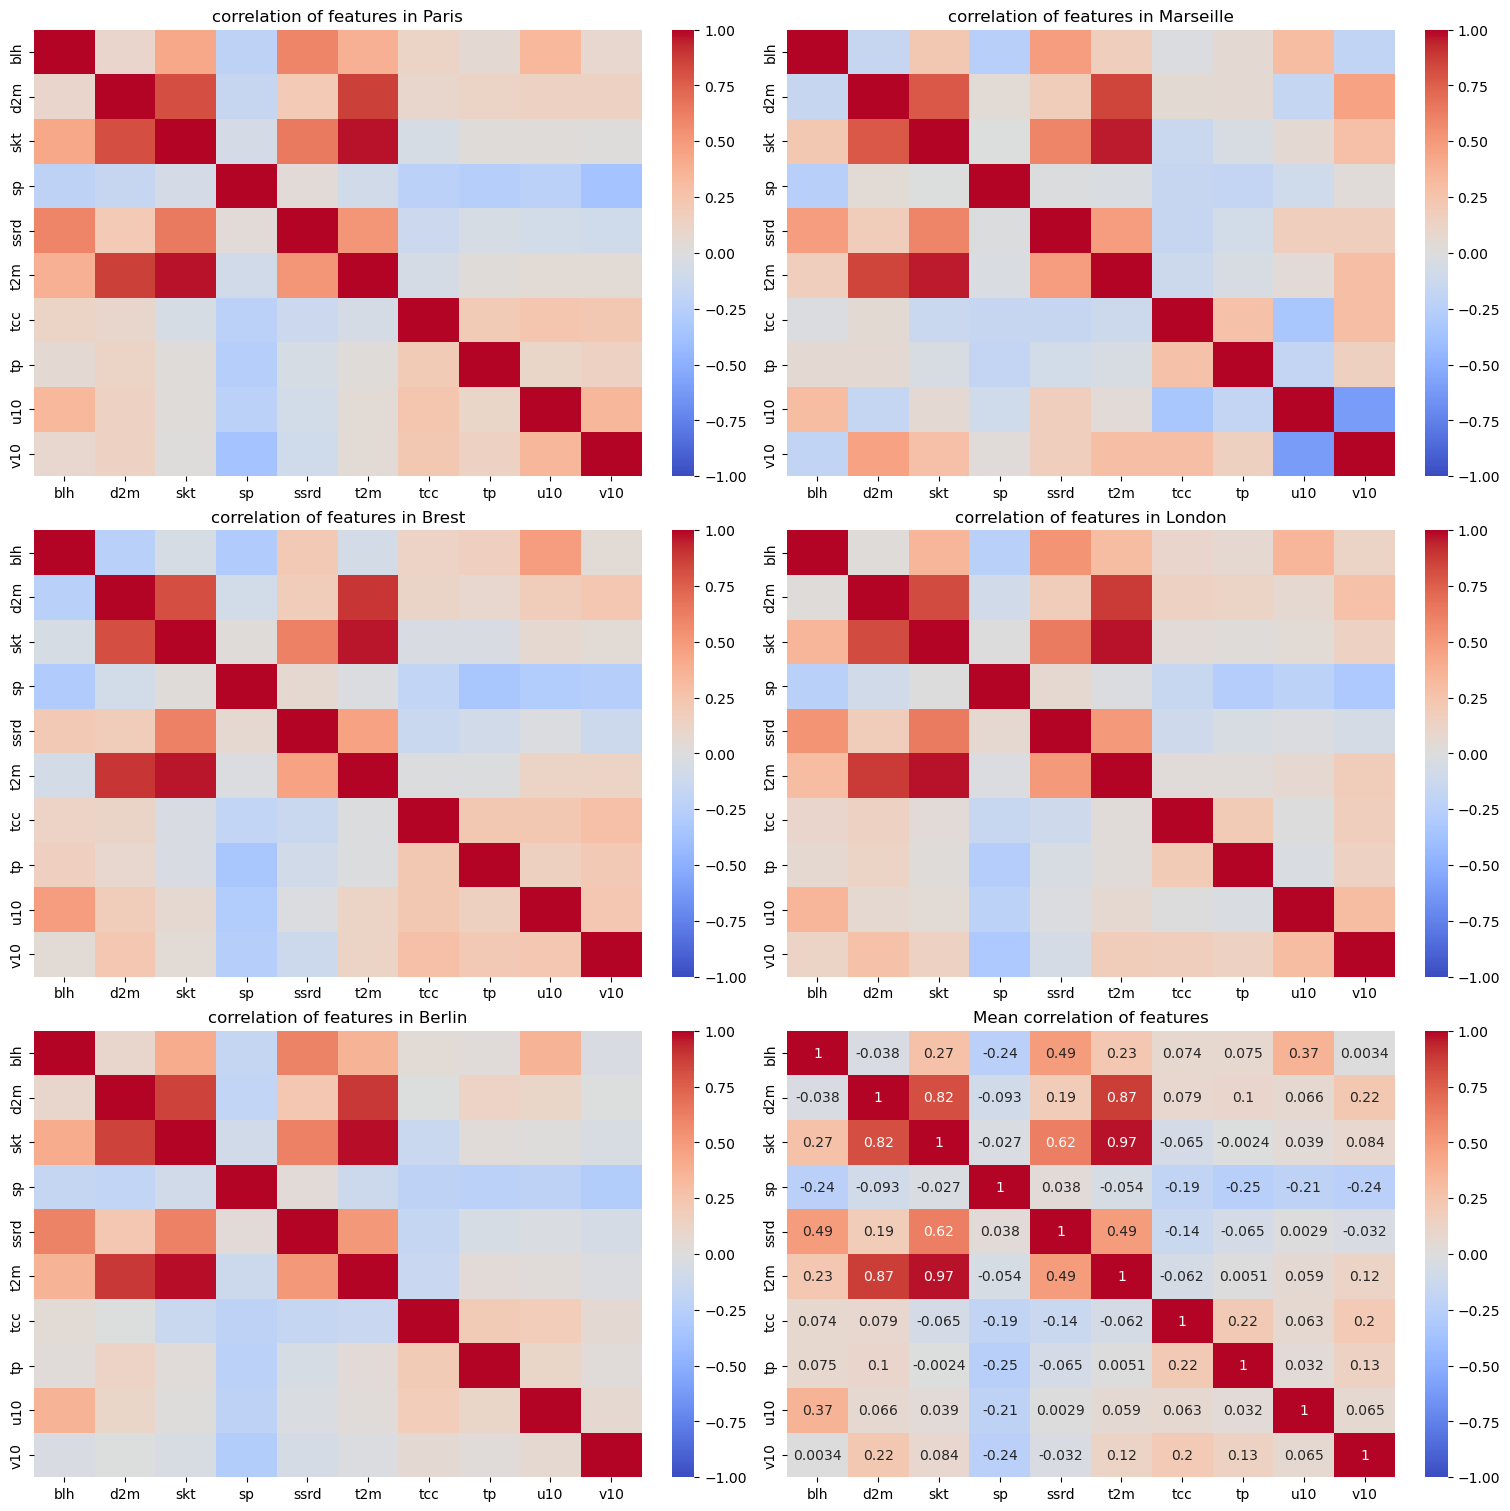

In [11]:
# Heat map of the correlation between the features for each city
fig, axs = plt.subplots(3, 2, figsize=(15, 15), layout="constrained")
axs = axs.flatten()
for city, ax in zip(cities, axs):
    sns.heatmap(
        weather_stations_data[city].corr(), cmap="coolwarm", vmin=-1.0, vmax=1.0, ax=ax
    )
    ax.set_title(f"correlation of features in {city.capitalize()}")

# Mean correlation accros the cities
sns.heatmap(
    pd.concat([weather_stations_data[city].corr() for city in cities])
    .groupby(level=0)
    .mean(),
    cmap="coolwarm",
    vmin=-1.0,
    vmax=1.0,
    ax=axs[-1],
    annot=True,
)
axs[-1].set_title("Mean correlation of features")

plt.show()

<div class="alert alert-block alert-info">

The bottom right heat map show the correlation across the whole dataset. It confirms the correlation between the temperatures features. However The feature `ssrd` - that was not plot above - also have a 
strong correlation with `blh`, `skt` and `t2m`.

At -0.25, the correlation between the pressure and precipitation is not relevant but, the negative sign confirms that a low pressure is needed for the rain.
</div>

#### 2.3.2 Covariance between cities

As we are expecting to predict the weather feature of Paris, we want to check if there is a correlation between the variables across the cities **at the same timestep**.

In [ ]:
# To compute easily the correlation, we need to transpose the structure of the
# dataframe from cities to variables
var_datasets: dict[str, pd.DataFrame] = (
    load_data.transpose_df_dict_from_cities_to_variables(weather_stations_data)
)
# var_datasets["d2m"].head()

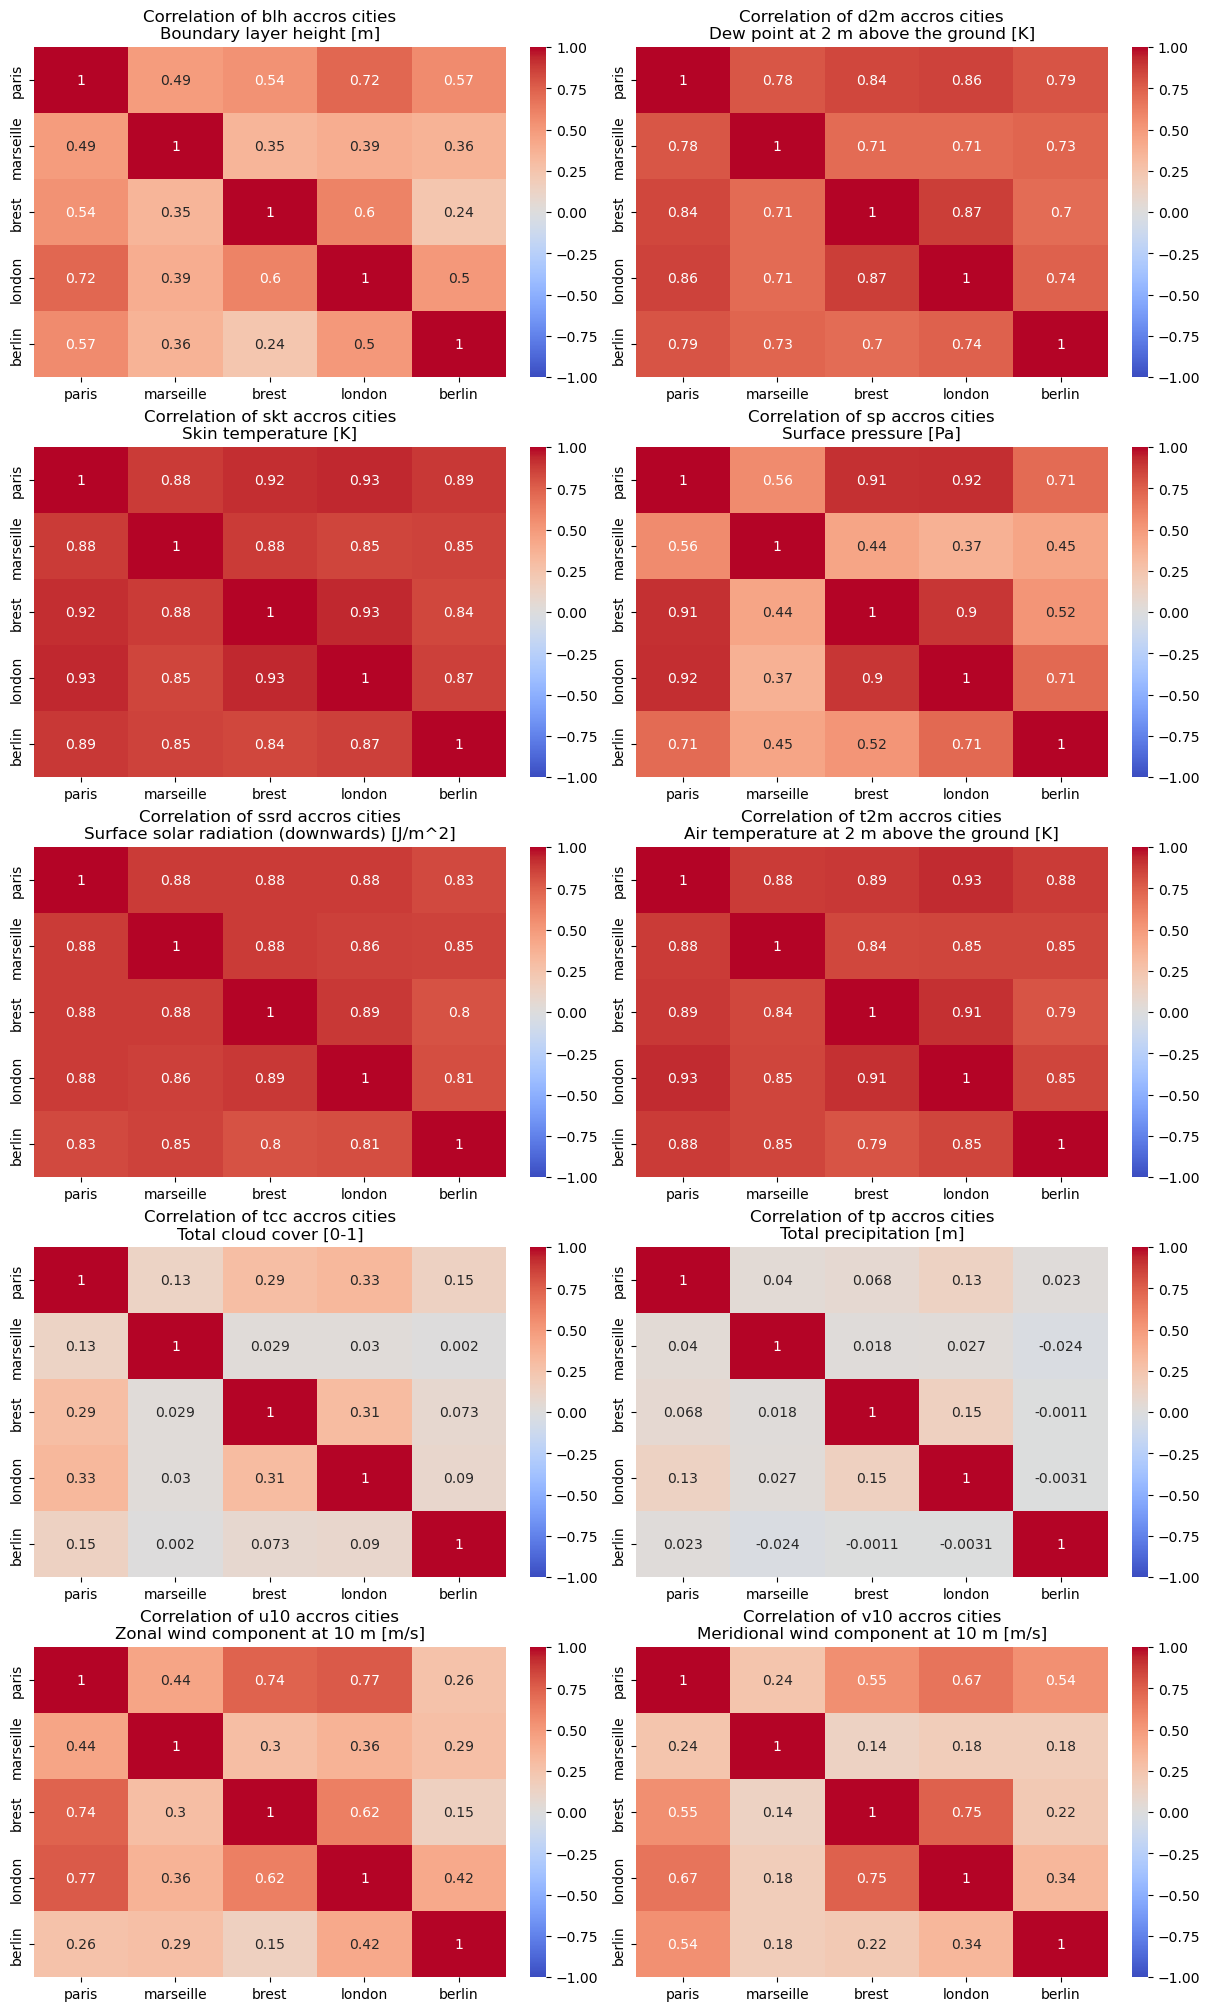

In [13]:
# Heat map of the correlation between cities for each variable
fig, axs = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axs = axs.flatten()
for ax, (var, df) in zip(axs, var_datasets.items()):
    sns.heatmap(
        df.corr(),
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"Correlation of {var} accros cities\n{display.var_legend[var]}")

<div class="alert alert-block alert-info">

**Correlation analysis**:<br>
We have different cases of correlation:
- The bright red heatmaps of the upper part confirm that temperature (`d2m, skt, t2m`) and solar radiation (`ssrd`) are highly correlated across cities.
- At the opposite, the cloud cover (`tcc`) and precipitation (`tp`) are rather local phenomenons.
- Finally, the winds (`u10, v10`) and pressure are geographically correlated: Paris is close to Brest and London, but the values for Marseille and Berlin are farther away, as the cities are.

</div>

### 2.4 Discovery of cycles in features

To discover cycles in the dataset, we will resample the dataset to get the average value :
- by day and plot a full year to discover seasonal patterns. (left column)
- by hour across the year to discover daily pattern. (right column)

To ease the visual comprehension, the features without cycle will be displayed on a gray background. We have selected the years 2013 to 2015.

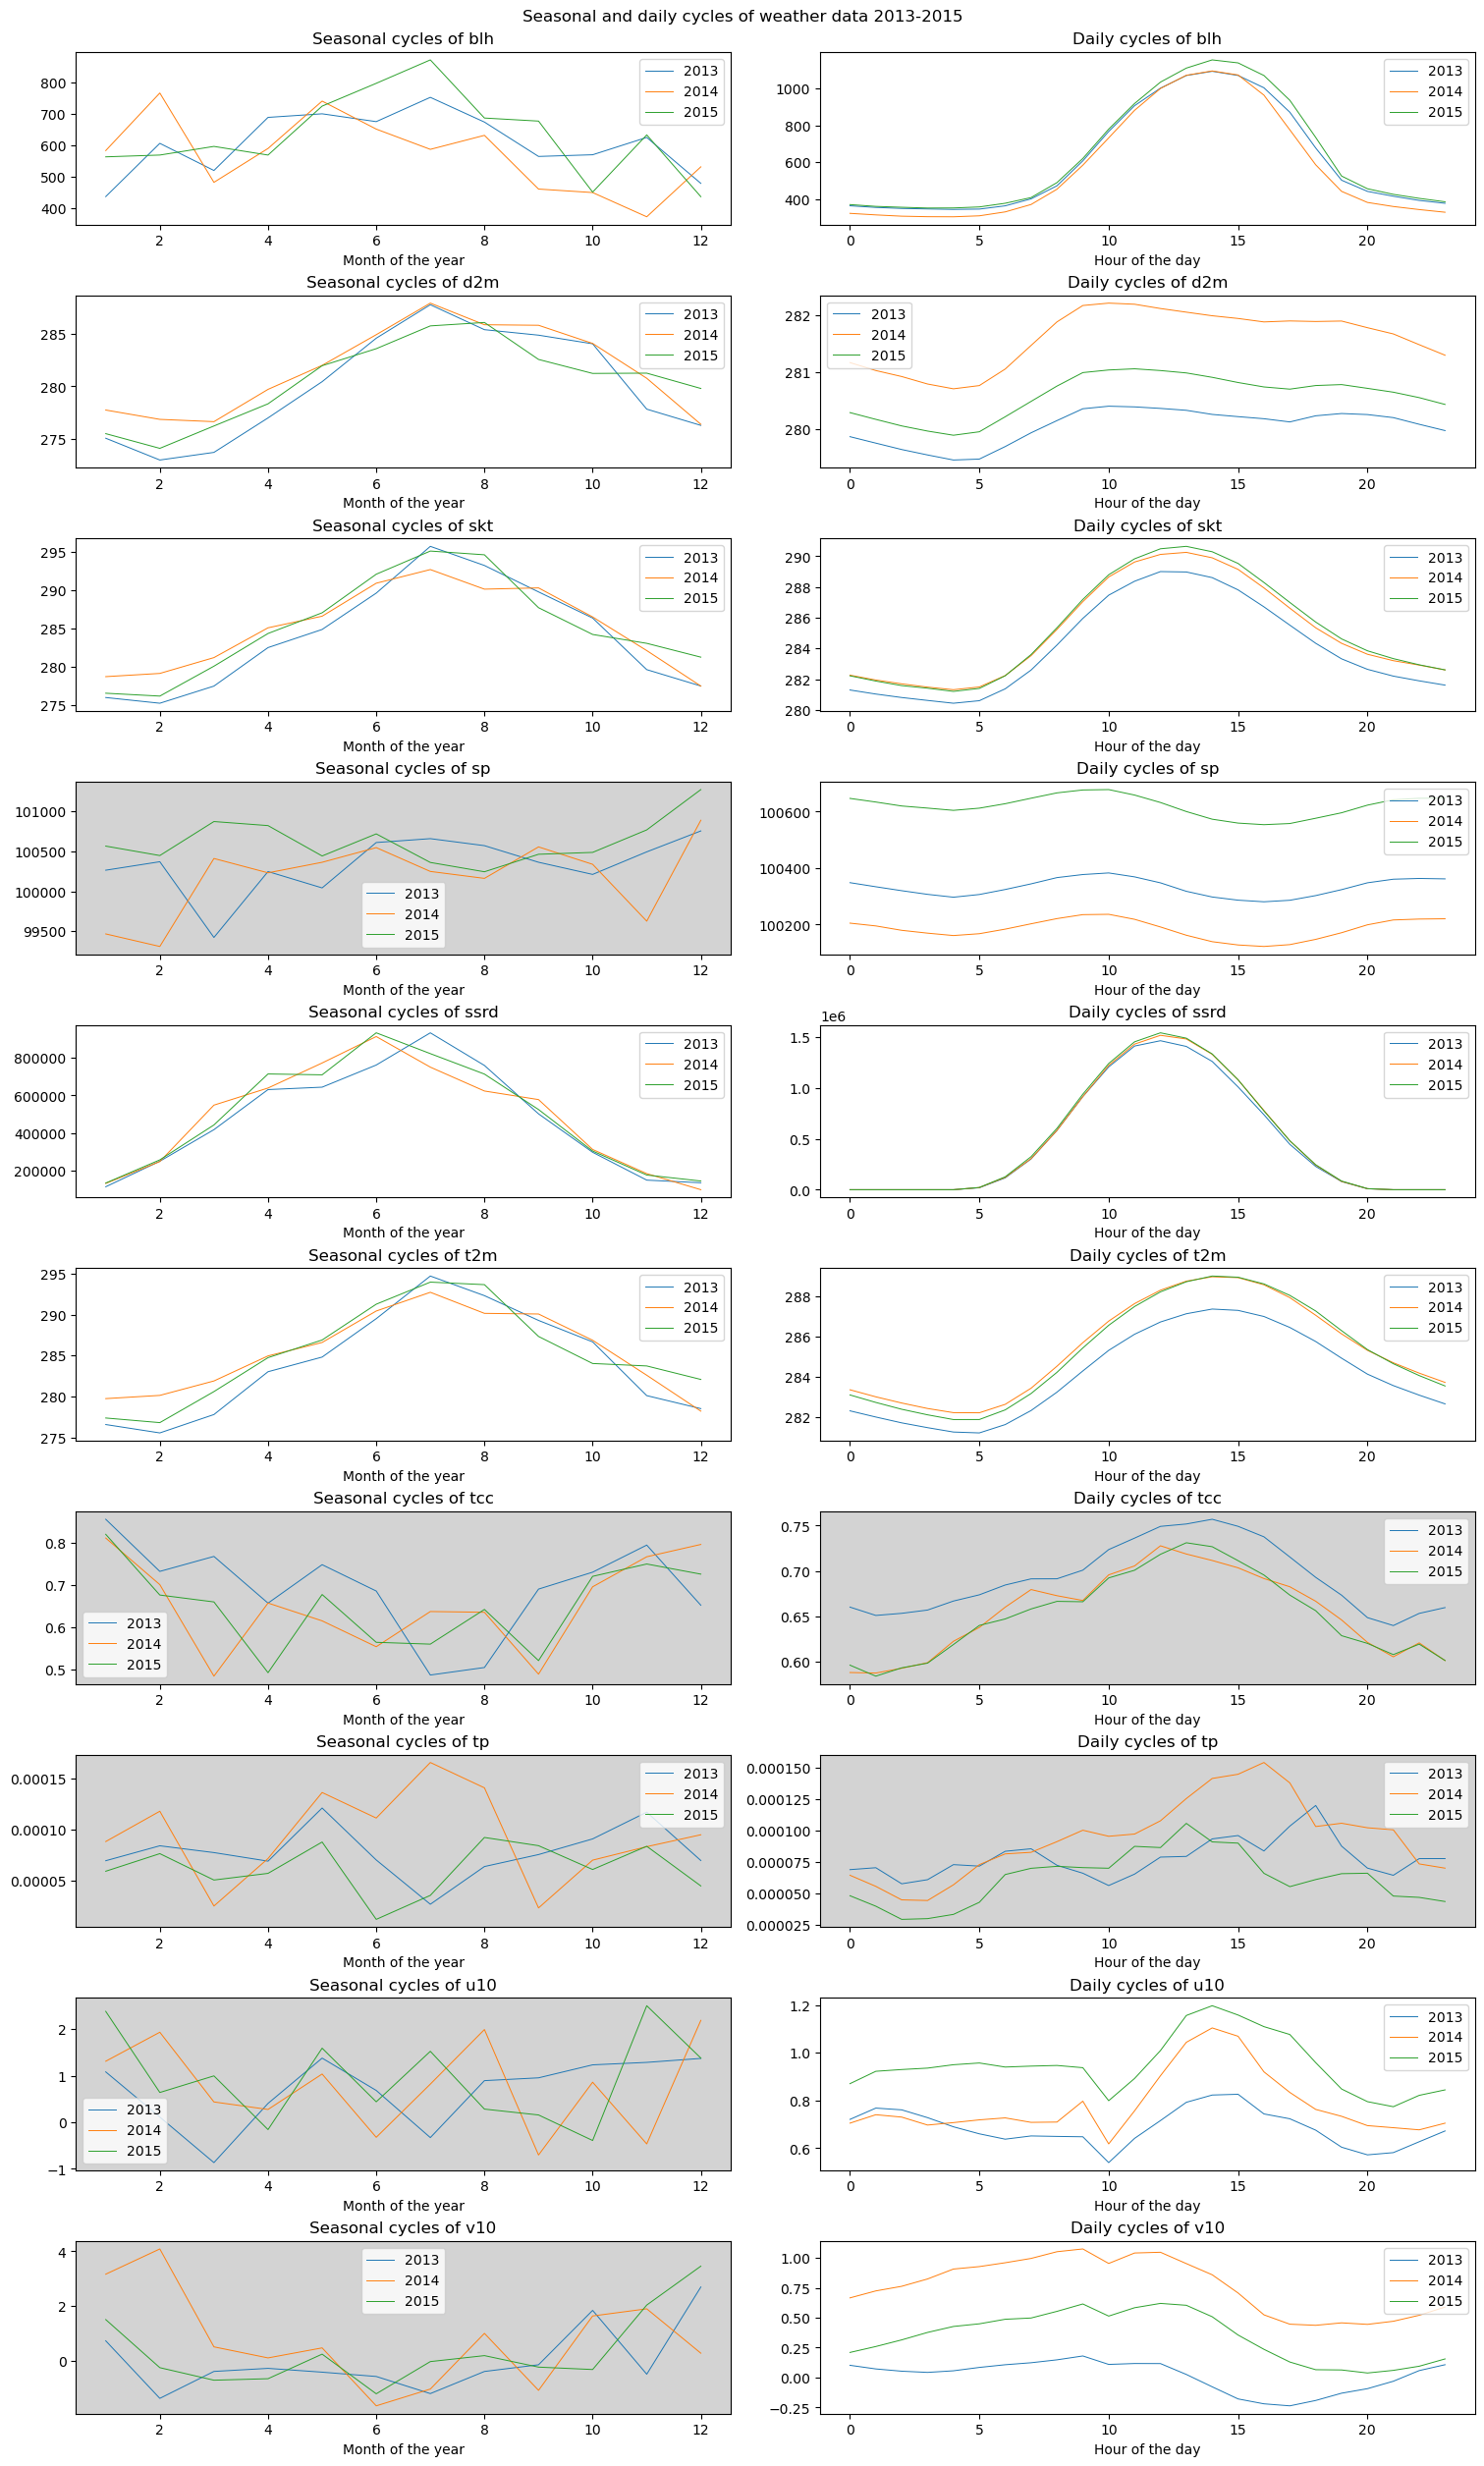

In [14]:
display.display_cycles(weather_stations_data["paris"], 2013, 2015)

<div class="alert alert-block alert-info">

**Cycle analysis**: <br>
This two kind of cycles may guide us during the **feature engineering part**.
It may be useful to feed the model with data at the same point on a previous cycle to help the prediction.

</div>

### 2.5 Reduce to a daily sample.

To speed up the computational cost, we will reduce the size dataset.
We will keep **only the 13 last years (train: 2007-2015, test: 2016-2018, validation: 2019)**, and **reduce to a daily sample**. Note that variables are averaged but `tp` and `ssrd` are summed. 

Then, all datasets will be **merged in a single DataFrame gathering all variables for all cities but Paris**. This data will be saved in the `data/red_data` folder as csv files.

Finally, this X and y are split by group of years. We will get 6 Pandas DataFrame of respective size:
- X_train_red : 10 * 365 rows x 4 * 10 columns
- X_test_red : 3 * 365 rows x 4 * 10 columns
- y_train_red : 10 * 365 rows x 1 * 10 columns
- y_test_red : 3 * 365 rows x 1 * 10 columns
- X_val_red : 1 * 365 rows x 4 * 10 columns
- y_val_red : 1 * 365 rows x 1 * 10 columns


Ultimately, these datasets will be normalized after the splitting.

#### 2.5.1 Reduce the dataset and create X/y dataset

In [ ]:
# Reduce to a daily sample and create X and y datasets
start_year = 2007
end_year = 2019
target_city = "paris"
save_path = Path("data", "red_data")
X_red, Y_red = load_data.create_daily_X_y_datasets(
    weather_stations_data, target_city, start_year, end_year, save_path=save_path
)

# Control the shape of the datasets
print(f"X_red shape: {X_red.shape}, y_red shape: {Y_red.shape}")

X_red shape: (4748, 40), y_red shape: (4748, 10)


#### 2.5.2 Split the dataset by dates
The two cells below aim to illustrate the steps in the split of the data but the action will be incorporated in the next step.

In [16]:
# Checkpoint: load the reduced data
save_path = Path("data", "red_data")
X_red = pd.read_csv(save_path / "X_red.csv", index_col=0, parse_dates=True)
Y_red = pd.read_csv(save_path / "Y_red.csv", index_col=0, parse_dates=True)

In [ ]:
# Split the data into train, test and validation sets
end_train_date = "2016-01-01"
end_test_date = "2019-01-01"
X_train, X_test, X_val = load_data.split_train_test_val(
    X_red, end_train_date, end_test_date
)
Y_train, Y_test, Y_val = load_data.split_train_test_val(
    Y_red, end_train_date, end_test_date
)
# control the sizes
print(f"{X_train.shape=}, {X_test.shape=}, {X_val.shape=}")
print(f"{Y_train.shape=}, {Y_test.shape=}, {Y_val.shape=}")

X_train.shape=(3287, 40), X_test.shape=(1096, 40), X_val.shape=(365, 40)
Y_train.shape=(3287, 10), Y_test.shape=(1096, 10), Y_val.shape=(365, 10)


#### 2.5.3 Final dataset: **reduced and normalized** measurments

<div class="alert alert-block alert-warning">

**Quickstart**: <br>
You can start the notebook from here.
</div>

In [2]:
# Load the prepared data and normalize by variable
# Start back from the checkpoint
save_path = Path("data", "red_data")
end_train_date = "2016-01-01"
end_test_date = "2019-01-01"

X_train_rn, X_test_rn, X_val_rn, y_train_rn, y_test_rn, y_val_rn, scalers = (
    load_data.load_red_norm_data(save_path, end_train_date, end_test_date)
)
# Control the shapes
print(
    f"Shapes of datasets: \nX_train: {X_train_rn.shape}, X_test_: {X_test_rn.shape}, X_val: {X_val_rn.shape}\n"
    f"y_train: {y_train_rn.shape}, y_test: {y_test_rn.shape}, y_val: {y_val_rn.shape}"
    f" with {len(scalers)} RobustScalers"
)

Shapes of datasets: 
X_train: (3287, 40), X_test_: (1096, 40), X_val: (365, 40)
y_train: (3287, 10), y_test: (1096, 10), y_val: (365, 10) with 10 RobustScalers


<div class="alert alert-block alert-info">

This is the end of the first part of the data preparation. It is important to **keep the scalers** in memory. Because if normalized features allow comparisons of the models, it prevents any interpretability of the results.
</div>

---
## 3. Prediction of Paris Weather
Supervised regression
use cross validation with seeds to allow reproductibility.

### 3.0 Baseline : Linear regressor


Do we have different result when focusing only on one feature or are we more accurate when using all available features of the dataset?

In the following colored-gradients, we are expecting to have the most dark green / low value cells.

#### 3.0.1. Linear regressor per feature

In [3]:
# Baseline model: Linear regression for each variable
target_variables_names = list(y_train_rn.keys())

# Create a linear regression model for each variable
y_pred = []
for variable in target_variables_names:
    variable_name = variable.split("_")[1]
    model = LinearRegression()
    # Select only the corresponding columns
    related_columns = [col for col in X_train_rn.columns if variable_name in col]
    # print(f"Variable: {variable}, related columns: {related_columns}")
    model.fit(X_train_rn[related_columns], y_train_rn[variable])
    # print(f"Model fitted for {variable}:{model.coef_}")
    y_pred.append(model.predict(X_test_rn[related_columns]))
# Concatenate the predictions into a dataframe
y_pred = pd.DataFrame(
    np.array(y_pred).T, index=X_test_rn.index, columns=target_variables_names
)
# Display the result in the standardized dataframe
print(f"MSE per variable for the baseline model per variables: {model}")
baseline_df, styled_df = display.display_mse_by_year(y_pred, y_test_rn)
styled_df


MSE per variable for the baseline model per variables: LinearRegression()


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.166761,0.062701,0.039654,0.009005,0.085802,0.046109,0.248094,3.223900,0.046913,0.140415
2017,0.193160,0.051314,0.033328,0.009482,0.071674,0.043901,0.210177,3.543318,0.045133,0.129609
2018,0.178478,0.069938,0.044037,0.020020,0.074057,0.048910,0.232721,3.370375,0.054735,0.157305
all,0.179466,0.061318,0.039006,0.012836,0.077178,0.046307,0.230331,3.379198,0.048927,0.142443


#### 3.0.2 Global linear regressor

In [4]:
# Baseline model: Linear regression for all variables
model = LinearRegression()
model.fit(X_train_rn, y_train_rn)
y_pred = model.predict(X_test_rn)
# load into a dataframe
y_pred = pd.DataFrame(y_pred, index=X_test_rn.index, columns=target_variables_names)
# Display the result in the standardized dataframe
print(f"MSE per variable for the baseline model global: {model}")
baseline_global_df, styled_df = display.display_mse_by_year(y_pred, y_test_rn)
styled_df

MSE per variable for the baseline model global: LinearRegression()


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.142424,0.045776,0.036308,0.001665,0.069907,0.040994,0.206956,2.554993,0.017333,0.042979
2017,0.142414,0.041109,0.024748,0.001933,0.059055,0.030950,0.177964,2.966685,0.017705,0.043503
2018,0.138695,0.059709,0.035873,0.002542,0.061844,0.044294,0.204308,2.782853,0.063525,0.133017
all,0.141178,0.048865,0.032310,0.002046,0.063602,0.038746,0.196409,2.768177,0.032854,0.073167


In [5]:
print("Base line vs global model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_df, baseline_global_df)
styled_df

Base line vs global model, reduction of MSE per variable


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.024338,0.016925,0.003346,0.007340,0.015895,0.005115,0.041138,0.668907,0.029580,0.097436
2017,0.050746,0.010205,0.008579,0.007550,0.012619,0.012951,0.032214,0.576633,0.027428,0.086106
2018,0.039783,0.010229,0.008164,0.017478,0.012213,0.004616,0.028414,0.587522,-0.008790,0.024288
all,0.038289,0.012453,0.006697,0.010789,0.013576,0.007561,0.033922,0.611020,0.016073,0.069277


<div class="alert alert-block alert-info">

**Baseline model**:<br>
Our global baseline model is a `LinearRegression` fitted on all $40$ available features that predicts the $10$ features of Paris in one pass. It uses only $10 \times 40+10 = 50$ coefficients and these coefficients are computed nearly instantaneously.

The use of all features improved the prediction of the `tp` variable.

**$\Rightarrow$ The global model is our new baseline model.**

</div>

#### Visualize the predictions of the first month

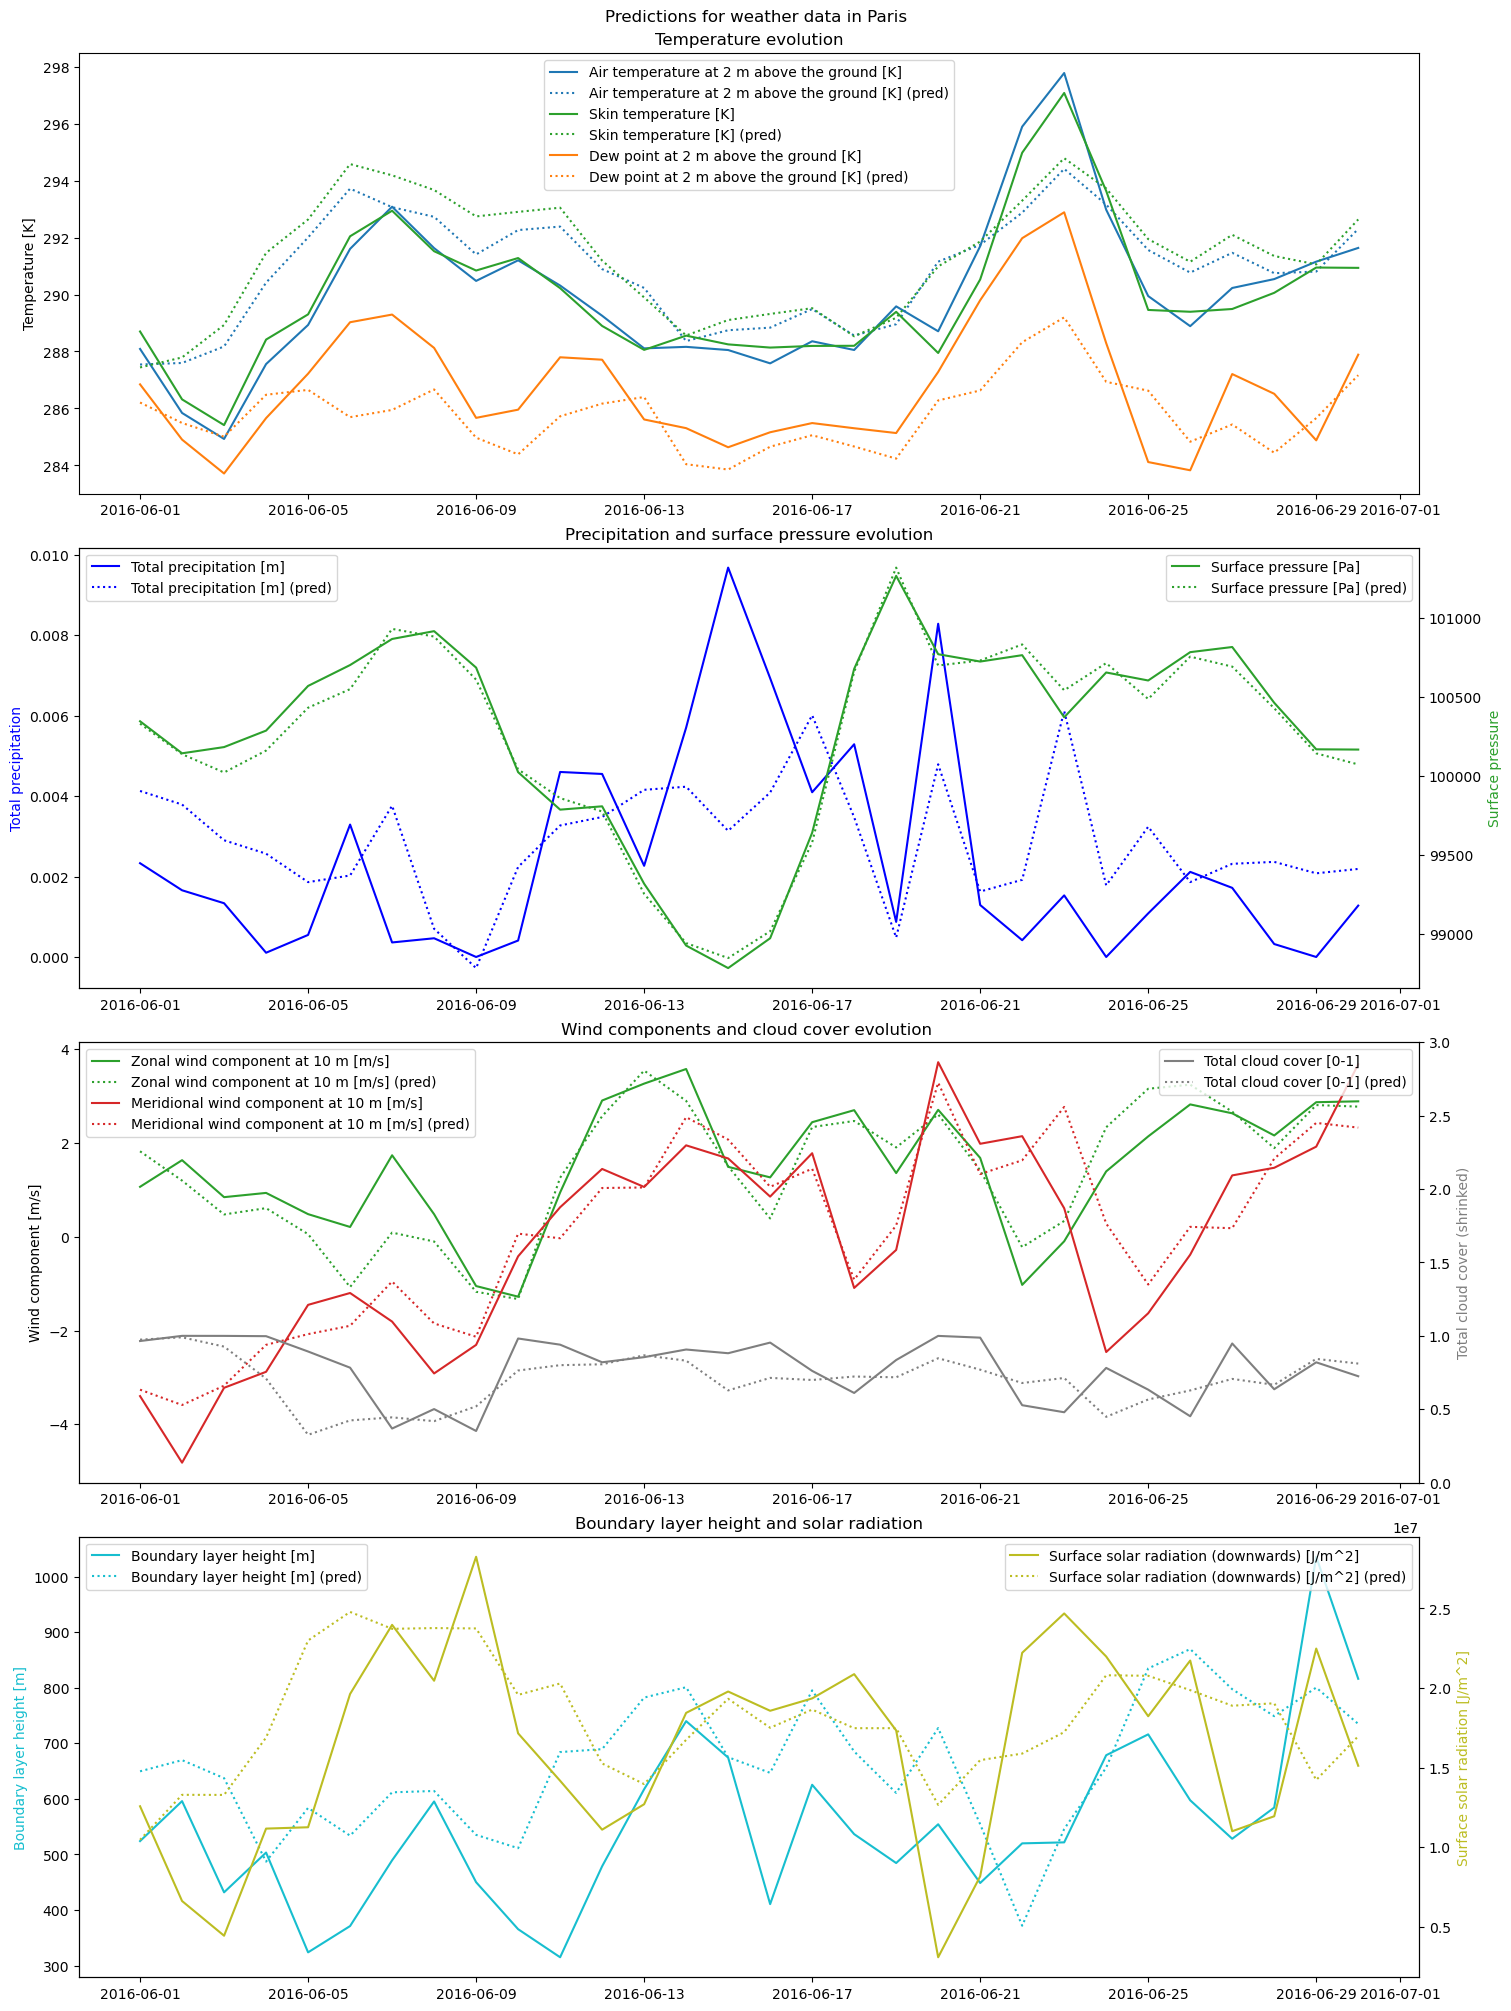

In [8]:
# Display the predictions and the actual values for the first 30 days of the test set = june 2016
display.display_predictions_with_actual(
    y_pred, y_test_rn, scalers, from_date="2016-06-01", to_date="2016-06-30"
)

<div class="alert alert-block alert-info">

**Prediction visualisation**:<br>
Our global `LinearRegression` predicts coherent values for each feature. But the predicted dot lines are still far from the actual values. There is still some work to do.
</div>

### 3.1 Model 1
Linear Lasso ?


### 3.2 Model 2
Tree ?


### 3.3 Model 3 : SVR
Quadratic model

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

parameter_grid = {
    "kernel": ["rbf"],
    "epsilon": np.logspace(-2, 2, 20),
    "C": np.logspace(-1, 2, 20),
}
# Create a grid search regression model for each variable
y_pred = []
models_per_variable = {}
for variable in target_variables_names:
    variable_name = variable.split("_")[1]
    model = GridSearchCV(SVR(), param_grid=parameter_grid, n_jobs=-1, refit=True)
    # Select only the corresponding columns
    related_columns = [col for col in X_train_rn.columns if variable_name in col]
    print(f"Variable: {variable}, related columns: {related_columns}")
    model.fit(X_train_rn[related_columns], y_train_rn[variable].to_numpy())
    models_per_variable[variable] = model
    y_pred.append(model.predict(X_test_rn[related_columns]))

# Concatenate the predictions into a dataframe
y_pred = pd.DataFrame(
    np.array(y_pred).T, index=X_test_rn.index, columns=target_variables_names
)
# display the parameters of the best model for each variable:
print("Best parameters for each variable:")
for variable, model in models_per_variable.items():
    print(f"{variable} : {model.best_params_}")

# Display the result in the standardized dataframe
print(f"MSE per variable for the best SVR model per variables: {model.estimator}")
best_svr_df, styled_df = display.display_mse_by_year(y_pred, y_test_rn)
styled_df

Variable: paris_blh, related columns: ['marseille_blh', 'brest_blh', 'london_blh', 'berlin_blh']
Variable: paris_d2m, related columns: ['marseille_d2m', 'brest_d2m', 'london_d2m', 'berlin_d2m']
Variable: paris_skt, related columns: ['marseille_skt', 'brest_skt', 'london_skt', 'berlin_skt']
Variable: paris_sp, related columns: ['marseille_sp', 'brest_sp', 'london_sp', 'berlin_sp']
Variable: paris_ssrd, related columns: ['marseille_ssrd', 'brest_ssrd', 'london_ssrd', 'berlin_ssrd']
Variable: paris_t2m, related columns: ['marseille_t2m', 'brest_t2m', 'london_t2m', 'berlin_t2m']
Variable: paris_tcc, related columns: ['marseille_tcc', 'brest_tcc', 'london_tcc', 'berlin_tcc']
Variable: paris_tp, related columns: ['marseille_tp', 'brest_tp', 'london_tp', 'berlin_tp']
Variable: paris_u10, related columns: ['marseille_u10', 'brest_u10', 'london_u10', 'berlin_u10']
Variable: paris_v10, related columns: ['marseille_v10', 'brest_v10', 'london_v10', 'berlin_v10']
Best parameters for each variable:


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.157086,0.058834,0.039179,0.008573,0.082463,0.045268,0.253524,3.310542,0.042254,0.127157
2017,0.181384,0.050116,0.031357,0.008395,0.068410,0.040479,0.219900,3.592393,0.042543,0.113526
2018,0.171380,0.067390,0.048016,0.020032,0.069107,0.049680,0.234138,3.447702,0.051404,0.127098
all,0.169950,0.058780,0.039517,0.012333,0.073327,0.045143,0.235854,3.450212,0.045400,0.122594


In [70]:
print("Base line vs SVR model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_df, best_svr_df)
styled_df

Base line vs SVR model, reduction of MSE per variable


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,-0.014662,-0.013058,-0.002871,-0.006909,-0.012556,-0.004274,-0.046568,-0.755549,-0.024921,-0.084178
2017,-0.038970,-0.009007,-0.006608,-0.006462,-0.009355,-0.009529,-0.041937,-0.625708,-0.024838,-0.070023
2018,-0.032685,-0.007680,-0.012143,-0.017490,-0.007262,-0.005385,-0.029831,-0.664849,0.012120,0.005919
all,-0.028772,-0.009915,-0.007208,-0.010287,-0.009725,-0.006396,-0.039445,-0.682035,-0.012546,-0.049427


<div class="alert alert-block alert-info">

**SVR model**:<br>
Even with a grid search, the `SVR` model fainlty reaches the level of the baseline model. It is less performant on  all features and significant worse on `tp`. Furthermore, because the SVR can only predict one variable, We had to fit 10 different models.

However, we didn't take the time to test different kernels.


</div>

### 3.4 Model 4 : Deep learning

We have found out that some features have seasonal cycles. That means that the previous days will embed information about the current prediction. Furthermore, the last year value will also help predict.
As we look for patterns, we will use DL methods with short term memory and convolutional layers.

First we need to modify the input to have the previous days.

<div class="alert alert-block alert-warning">

**New Dataset**: <br>
In this part, we use an **enhanced dataset** with additional features.
</div>

#### 3.4.1 Baseline check

In [71]:
# Creating the dataset with a shift of 3 days
X_train_3 = load_data.add_shift_previous_days(X_train_rn, 3)
X_test_3 = load_data.add_shift_previous_days(X_test_rn, 3)

In [94]:
# check the metrics with a least square regression on this new data
model = LinearRegression()
model.fit(X_train_3, y_train_rn)
y_pred = model.predict(X_test_3)
# load into a dataframe
y_pred = pd.DataFrame(y_pred, index=X_test_rn.index, columns=target_variables_names)
lr_shift, _ = display.display_mse_by_year(y_pred, y_test_rn)
_, styled = display.display_delta(baseline_global_df, lr_shift)
styled


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.010441,0.007623,0.003907,-0.000041,0.007065,0.004703,0.010159,-0.030739,-0.000011,-0.001557
2017,0.013205,0.006189,0.002521,0.000022,0.006112,0.004232,-0.000651,0.018758,-0.000040,0.000552
2018,-0.001532,-0.009902,-0.003412,0.000177,0.002001,-0.003843,-0.001748,-0.080847,0.005658,0.034914
all,0.007371,0.001304,0.001006,0.000052,0.005059,0.001697,0.002587,-0.030943,0.001869,0.011303


In [79]:
print(
    f"Overall mse improved of {lr_shift.loc["all"].mean() - baseline_global_df.loc["all"].mean():.5f} points with this model."
)

Overall mse improved of -0.00013 points with this model.


<div class="alert alert-block alert-info">

The `LinearRegression` on all additional features leads to a small improvement of the mse on all features but `tp`. This means the history of the 3 previous days help the model predict.

**But on average, the overall mse has not improved.** Let's try to correct it with DL models.
</div>

#### 3.4.2 Tensor preparation

To use deep learning models, we are using PyTorch. Hence, the dataset have to be 
transformed into `Tensors` and loaded with a specific dataloader.

In [ ]:
# Data loader for the neural network
batch_size = 32
train_loader: DataLoader = DL_models.create_data_loader(
    X=X_train_3, y=y_train_rn, batch_size=batch_size, shuffle=False
)
test_loader: DataLoader = DL_models.create_data_loader(
    X=X_test_3, y=y_test_rn, batch_size=batch_size, shuffle=False
)

#### 3.4.3 GRU

In [ ]:
reload(DL_models)
# Model parameters
input_size = X_train_3.shape[1]
hidden_size = 64
output_size = y_train_rn.shape[1]
num_layers = 2
num_epochs = 100
learning_rate = 0.0001

# Initialize the model, loss function, and optimizer
model = DL_models.GRUModel(input_size, hidden_size, output_size, num_layers)
model_name = "GRU_model"
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 5/100 - Train loss: 0.4171 - Val loss: 0.4734
Epoch 10/100 - Train loss: 0.3335 - Val loss: 0.4082
Epoch 15/100 - Train loss: 0.3019 - Val loss: 0.3818
Epoch 20/100 - Train loss: 0.2812 - Val loss: 0.3666
Epoch 25/100 - Train loss: 0.2694 - Val loss: 0.3571
Epoch 30/100 - Train loss: 0.2583 - Val loss: 0.3501
Epoch 35/100 - Train loss: 0.2480 - Val loss: 0.3445
Epoch 40/100 - Train loss: 0.2406 - Val loss: 0.3400
Epoch 45/100 - Train loss: 0.2341 - Val loss: 0.3361
Epoch 50/100 - Train loss: 0.2236 - Val loss: 0.3331
Epoch 55/100 - Train loss: 0.2175 - Val loss: 0.3312
Epoch 60/100 - Train loss: 0.2094 - Val loss: 0.3293
Epoch 65/100 - Train loss: 0.2020 - Val loss: 0.3274
Epoch 70/100 - Train loss: 0.1995 - Val loss: 0.3259
Epoch 75/100 - Train loss: 0.1893 - Val loss: 0.3251
Epoch 80/100 - Train loss: 0.1845 - Val loss: 0.3254
Epoch 85/100 - Train loss: 0.1772 - Val loss: 0.3254
Epoch 90/100 - Train loss: 0.1715 - Val loss: 0.3259
Epoch 95/100 - Train loss: 0.1641 - Val loss: 0

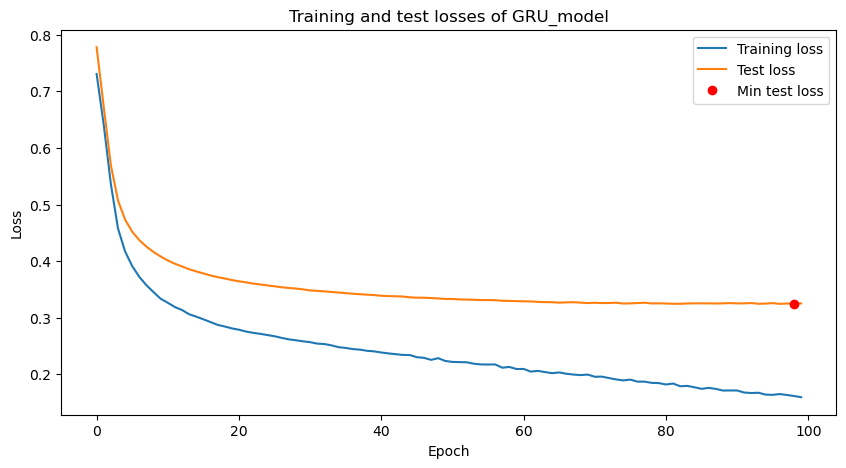

In [ ]:
# Train the model
RETRAIN_MODELS = True
if RETRAIN_MODELS:
    train_losses, test_losses = DL_models.train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs, 5
    )
    DL_models.save_model(model, model_name)
    # Display the losses
    display.display_losses(train_losses, test_losses, model_name)
else:
    model = DL_models.load_model(model, model_name)

The model will clearly overfitt after 100 epochs. We needed to tune the learning rate and have added a dropout layer after the last GRU to help the model generalize.

In [184]:
# Evaluate the GRU model
reload(DL_models)
y_pred, _ = DL_models.evaluate_model(model, test_loader, criterion)
y_pred = pd.DataFrame(y_pred, index=X_test_rn.index, columns=target_variables_names)
gru_df, styled_df = display.display_mse_by_year(y_pred, y_test_rn)
styled_df

,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.096770,0.043348,0.033334,0.016835,0.068301,0.035784,0.187961,2.263288,0.032184,0.068362
2017,0.106977,0.044719,0.031916,0.017529,0.058533,0.035078,0.174037,3.112739,0.033790,0.062591
2018,0.110949,0.050816,0.037332,0.019914,0.063743,0.039535,0.174227,2.769220,0.043728,0.067677
all,0.104899,0.046294,0.034194,0.018093,0.063526,0.036799,0.178742,2.715082,0.036567,0.066210


In [185]:
# Compare the GRU model with the baseline model
print("Base line vs GRU model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_df, gru_df)
styled_df


Base line vs GRU model, reduction of MSE per variable


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.045653,0.002428,0.002974,-0.015170,0.001606,0.005210,0.018995,0.291705,-0.014851,-0.025383
2017,0.035437,-0.003610,-0.007167,-0.015596,0.000521,-0.004128,0.003927,-0.146053,-0.016085,-0.019087
2018,0.027746,0.008893,-0.001459,-0.017372,-0.001899,0.004759,0.030081,0.013633,0.019797,0.065341
all,0.036279,0.002570,-0.001884,-0.016046,0.000076,0.001947,0.017667,0.053095,-0.003713,0.006957


In [192]:
print(
    f"Overall mse improved of {baseline_global_df.loc["all"].mean() - gru_df.loc["all"].mean():.5f} points with {model_name}."
)

Overall mse improved of 0.00969 points with Conv1D_model.


<div class="alert alert-block alert-info">

The `GRU` model improved our predictions on seven of the features.

**On average, the overall mse has slightly improved.** Mission completed.
</div>

#### 3.4.4 CONV1D

In [ ]:
reload(DL_models)
# Model parameters
input_size = X_train_3.shape[1]
output_size = y_train_rn.shape[1]
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = DL_models.Conv1DModel(input_size, output_size)
model_name = "Conv1D_model"
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
if RETRAIN_MODELS:
    train_losses, test_losses = DL_models.train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs, 5
    )
    DL_models.save_model(model, model_name)
    # Display the losses
    display.display_losses(train_losses, test_losses, model_name)
else:
    model = DL_models.load_model(model, model_name)

Model loaded from models/Conv1D_model.pt


In [194]:
# Evaluate the CONV1D model
y_pred, _ = DL_models.evaluate_model(model, test_loader, criterion)
y_pred = pd.DataFrame(y_pred, index=X_test_rn.index, columns=target_variables_names)
conv1D_df, styled_df = display.display_mse_by_year(y_pred, y_test_rn)
styled_df

,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,0.211347,0.093274,0.086980,0.128904,0.089282,0.101276,0.299866,3.394299,0.156247,0.238518
2017,0.271132,0.099212,0.076581,0.111178,0.106269,0.095160,0.284660,3.651497,0.138885,0.227089
2018,0.244045,0.118245,0.097942,0.117388,0.095500,0.113422,0.301516,3.303346,0.187169,0.228873
all,0.242175,0.103577,0.087168,0.119157,0.097017,0.103286,0.295348,3.449714,0.160767,0.231494


In [195]:
# Compare the CONV1D model with the baseline model
print("Base line vs CONV1D model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_df, conv1D_df)
styled_df


Base line vs CONV1D model, reduction of MSE per variable


,paris_blh,paris_d2m,paris_skt,paris_sp,paris_ssrd,paris_t2m,paris_tcc,paris_tp,paris_u10,paris_v10
2016,-0.068924,-0.047498,-0.050672,-0.127239,-0.019374,-0.060282,-0.092910,-0.839306,-0.138915,-0.195539
2017,-0.128718,-0.058103,-0.051832,-0.109245,-0.047214,-0.064210,-0.106697,-0.684812,-0.121179,-0.183586
2018,-0.105350,-0.058536,-0.062069,-0.114846,-0.033655,-0.069128,-0.097209,-0.520493,-0.123645,-0.095856
all,-0.100997,-0.054712,-0.054858,-0.117110,-0.033415,-0.064540,-0.098939,-0.681537,-0.127913,-0.158327


In [191]:
print(
    f"Overall mse improved of {baseline_global_df.loc["all"].mean() - conv1D_df.loc["all"].mean():.5f} points with {model_name}."
)

Overall mse improved of -0.14923 points with Conv1D_model.


#### 3.4.1 GRU

#### 3.4.5 other DL ???

### 3.5 Model comparison

---
## 4. Detection of anomalies
unsupervised classification

## 5. Conclusion

About the dataset
About the project and objectives
About the team organisation

If we had to do it again:
- keep:
- change: